In [16]:
from casadi import *
import numpy as np

In [17]:
opti = casadi.Opti()
dt=0.2
N=20

linear_states=opti.variable(6)
angular_states=opti.variable(6)
n_states=12
states=vertcat(linear_states, angular_states)


control_states=opti.variable(4)
n_controls=4
controls=vertcat(control_states)


g=9.81
m=1
Ixx=0.0092
Iyy=0.0093
Izz=0.0151
d1x=0.2
d2x=d1x
d3x=d1x
d4x=d1x
d1y=d1x
d2y=d1x
d3y=d1x
d4y=d1x


Fz=(control_states[0]+control_states[1]+control_states[2]+control_states[3])
L=control_states[0]*d1y-control_states[1]*d2y-control_states[2]*d3y+control_states[3]*d4y
M=control_states[0]*d1x-control_states[1]*d2x+control_states[2]*d3x-control_states[3]*d4x

l=0.42

Nz=-control_states[0]*l-control_states[1]*l+control_states[2]*l+control_states[3]*l

In [18]:

dx=cos(angular_states[1])*cos(angular_states[2])*linear_states[3]+(-cos(angular_states[0])*sin(angular_states[2])+sin(angular_states[0])*sin(angular_states[1])*cos(angular_states[2]))*linear_states[4]+(sin(angular_states[0])*sin(angular_states[2])+cos(angular_states[0])*sin(angular_states[1])*cos(angular_states[2]))*linear_states[5]
dy=cos(angular_states[1])*sin(angular_states[2])*linear_states[3]+(cos(angular_states[0])*cos(angular_states[2])+sin(angular_states[0])*sin(angular_states[1])*sin(angular_states[2]))*linear_states[4]+(-sin(angular_states[0])*cos(angular_states[2])+cos(angular_states[0])*sin(angular_states[1])*sin(angular_states[2]))*linear_states[5]
dz=-1*(-sin(angular_states[1])*linear_states[3]+sin(angular_states[0])*cos(angular_states[1])*linear_states[4]+cos(angular_states[0])*cos(angular_states[1])*linear_states[5])
du=-g*sin(angular_states[1])-angular_states[5]*linear_states[4]-angular_states[4]*linear_states[5]
dv=g*sin(angular_states[0])*cos(angular_states[1])-angular_states[5]*linear_states[3]+angular_states[3]*linear_states[5]
dw=(1/m)*(-Fz)+g*cos(angular_states[0])*cos(angular_states[1])+angular_states[4]*linear_states[3]-angular_states[3]*linear_states[4]
dphi=angular_states[3]+(angular_states[4]*sin(angular_states[0])+angular_states[5]*cos(angular_states[0]))*tan(angular_states[1])
dtheta=angular_states[4]*cos(0)-angular_states[5]*sin(angular_states[0])
dpsi=(angular_states[4]*sin(angular_states[0])+angular_states[5]*cos(angular_states[0]))*1/(cos(angular_states[1]))
dp=(1/Ixx)*(L+(Iyy-Izz)*angular_states[4]*angular_states[5])
dq=(1/Iyy)*(M+(Izz-Ixx)*angular_states[3]*angular_states[5])
dr=(1/Izz)*(Nz+(Ixx-Iyy)*angular_states[3]*angular_states[4])


rhs=vertcat(dx,dy,dz,du,dv,dw,dphi,dtheta,dpsi,dp,dq,dr)

f=Function('f', [states, controls],[rhs])  #Non-linear mapping function

In [19]:
# Define state, control and parameter matrices
X=opti.variable(n_states,N+1)
U=opti.variable(n_controls,N)
P=opti.parameter(2*n_states)
# States Integration
X[:,0] = P[0:n_states] # Initial State
for k in range(N):
    st = X[:,k]
    con = U[:,k]
    f_value=f(st,con)
    st_next=st+dt*f_value
    X[:,k+1]=st_next
    # opti.subject_to(X[:,k+1]==st_next)

In [20]:
obj=0

# Defining weighing matrices
Q=np.eye(n_states, dtype=float)
Q=Q*0.5

R=np.eye(n_controls, dtype=float)
R=R*0.5

for k in range(N):
    st=X[:,k]
    con=U[:,k]
    obj=obj+mtimes(mtimes((st-P[n_states:2*n_states]).T,Q),(st-P[n_states:2*n_states]))+mtimes(mtimes(con.T, R), con)

opti.minimize(obj)

In [21]:
max_vel = 1
max_rot = 0.1
opti.subject_to(X[3,:]<=max_vel)
opti.subject_to(X[4,:]<=max_vel)
opti.subject_to(X[5,:]<=max_vel)

opti.subject_to(X[3,:]>=-max_vel)
opti.subject_to(X[4,:]>=-max_vel)
opti.subject_to(X[5,:]>=-max_vel)

opti.subject_to(X[9,:]<=max_rot)
opti.subject_to(X[10,:]<=max_rot)
opti.subject_to(X[11,:]<=max_rot)

opti.subject_to(X[9,:]>=-max_rot)
opti.subject_to(X[10,:]>=-max_rot)
opti.subject_to(X[11,:]>=-max_rot)


opti.solver('ipopt')

In [22]:
x0=vertcat(0,0,0,0,0,0,0,0,0,0,0,0)
xs=vertcat(10,10,10,0,0,0,0,0,0,0,0,0)

In [23]:
count=0
u0=np.zeros((n_controls,N))
while np.linalg.norm((xs-x0)) > 1e-2 and count<100:

    opti.set_value(P,vertcat(x0,xs))
    opti.set_initial(U,u0)
    sol=opti.solve()   
    u=sol.value(U)
    x=sol.value(X)
    
    st = x0
    con = u[:,0]
    f_value=f(st,con)
    x0=st+dt*f_value
    print(x0)

    u0=u


    count=count+1

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     9760
Number of nonzeros in Lagrangian Hessian.............:     2936

Total number of variables............................:      332
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      252
        inequality constraints with only lower bounds:      126
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      126

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1715071e+04 3.82e+01 8.51e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

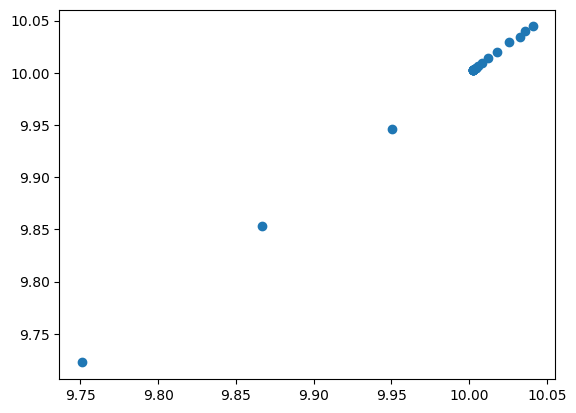

In [24]:
from matplotlib import pyplot as plt
plt.scatter(np.asarray(opti.debug.value(X)[0,:]), np.asarray(opti.debug.value(X)[1,:]))
plt.show()

In [25]:
opti.debug.value(X)

array([[ 1.00023069e+01,  1.00023092e+01,  1.00023109e+01,
         1.00023122e+01,  1.00023132e+01,  1.00024043e+01,
         1.00026828e+01,  1.00032599e+01,  1.00042759e+01,
         1.00059185e+01,  1.00084454e+01,  1.00122152e+01,
         1.00177403e+01,  1.00257285e+01,  1.00359788e+01,
         1.00408009e+01,  1.00326146e+01,  1.00043334e+01,
         9.95024604e+00,  9.86675811e+00,  9.75084079e+00],
       [ 1.00022365e+01,  1.00022384e+01,  1.00022398e+01,
         1.00022408e+01,  1.00022417e+01,  1.00023443e+01,
         1.00026606e+01,  1.00033208e+01,  1.00044912e+01,
         1.00063960e+01,  1.00093448e+01,  1.00137716e+01,
         1.00203029e+01,  1.00296771e+01,  1.00402437e+01,
         1.00443913e+01,  1.00347414e+01,  1.00041810e+01,
         9.94590949e+00,  9.85369858e+00,  9.72259807e+00],
       [ 1.00174205e+01,  1.00174210e+01,  1.00174215e+01,
         1.00176474e+01,  1.00182492e+01,  1.00193240e+01,
         1.00209283e+01,  1.00230791e+01,  1.00257470e